In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import netCDF4 as nc
import numpy as np
import pandas as pd

In [2]:
mask_df = pd.read_csv('data/term_landseamask.csv', sep=';')

In [3]:
mask_df = mask_df.sort_values(by=['lon', 'lat'])
mask_df

,id,i,j,lon,lat,index,olim
359,360,2,2,-179.75,-89.75,-999,2
358,359,2,3,-179.75,-89.25,-999,2
357,358,2,4,-179.75,-88.75,-999,2
356,357,2,5,-179.75,-88.25,-999,2
355,356,2,6,-179.75,-87.75,-999,2
...,...,...,...,...,...,...,...
258844,258845,721,357,179.75,87.75,-999,0
258843,258844,721,358,179.75,88.25,-999,0
258842,258843,721,359,179.75,88.75,-999,0
258841,258842,721,360,179.75,89.25,-999,0


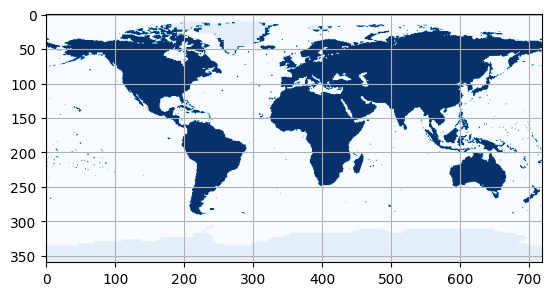

In [4]:
mask = np.array(mask_df['olim']).astype(float).reshape(720, 360).T

mask[mask == 2] = 0.1
plt.imshow(mask[::-1], cmap='Blues')
plt.grid()

In [5]:
lake_path = 'data/lakeAreaFrac_GLDB_corrected_grid0.5x0.5.nc'
lake_ds = nc.Dataset(lake_path)
lake_data = lake_ds['lakeAreaFrac'][:]
lake_data[lake_data != 0] = 1

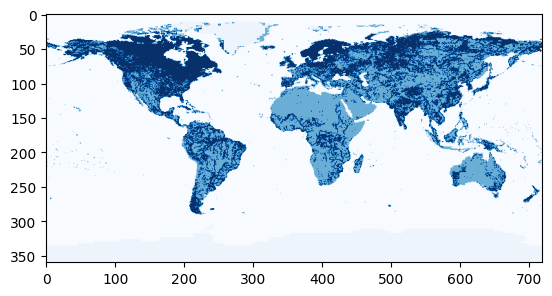

In [6]:
mask[mask == 1.] = lake_data[mask == 1.] + 1.
mask = mask[::-1]
plt.imshow(mask, cmap='Blues')

In [7]:
np.unique(mask)

array([0. , 0.1, 1. , 2. ])

In [8]:
def calculate_sums(mask, x_ticks, y_ticks):
    max_sum = 0
    for i in range(len(y_ticks) - 1):
        for j in range(len(x_ticks) - 1):
            rectangle = mask[y_ticks[i]:y_ticks[i+1], x_ticks[j]:x_ticks[j+1]]
            
            rectangle_sum = np.sum(rectangle)
            max_sum = max(rectangle_sum, max_sum)
    return max_sum

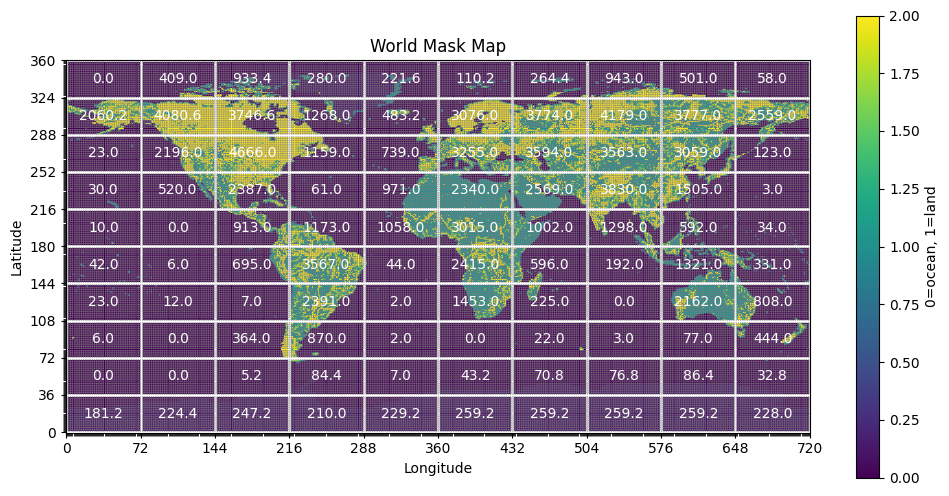

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_world_mask(mask, n=10, m=10, ni=None, mi=None):
    mask = mask[::-1]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    c = ax.imshow(mask, origin='lower', cmap='viridis')
    
    cbar = fig.colorbar(c, ax=ax, orientation='vertical')
    cbar.set_label('0=ocean, 1=land')
    
    x_ticks = [(mask.shape[1] // n) * i for i in range(n + 1)] if ni is None else ni
    y_ticks = [(mask.shape[0] // m) * i for i in range(m + 1)] if mi is None else mi
    ax.set_xticks(x_ticks, minor=False)
    ax.set_yticks(y_ticks, minor=False)
    ax.grid(which='major', color='white', linestyle='-', linewidth=2)
    

    for i in range(len(y_ticks) - 1):
        for j in range(len(x_ticks) - 1):
            rectangle = mask[y_ticks[i]:y_ticks[i+1], x_ticks[j]:x_ticks[j+1]]
            
            rectangle_sum = np.sum(rectangle).round(1)
            lon_center = x_ticks[j] + (x_ticks[j+1] - x_ticks[j]) // 2
            lat_center = y_ticks[i] + (y_ticks[i+1] - y_ticks[i]) // 2 
            ax.text(lon_center, lat_center, str(rectangle_sum), color='white', ha='center', va='center')

    ax.set_xticks(np.arange(0, 720, 1), minor=True)
    ax.set_yticks(np.arange(0, 360, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('World Mask Map')

    plt.savefig('mask_map_upd.jpg')

plot_world_mask(mask)


In [10]:
n = 10
m = 10
x_ticks = [(mask.shape[1] // n) * i for i in range(n + 1)]
y_ticks = [(mask.shape[0] // m) * i for i in range(m + 1)]

calculate_sums(mask, x_ticks, y_ticks)

4666.0

In [11]:
nproc = 100
vlines = []

all_sum = np.sum(mask)
column_mean = all_sum / nproc
column_sums = np.sum(mask, axis=0)

all_col_sum = all_sum
current_sum = 0
vlines_left = nproc
for idx, elem in enumerate(column_sums):
    if current_sum >= column_mean:
        vlines.append(idx)
        vlines_left -= 1
        column_mean = all_col_sum / vlines_left
        current_sum = 0
    all_col_sum -= elem
    current_sum += elem

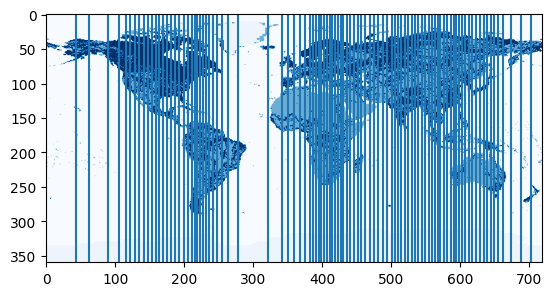

In [12]:
plt.imshow(mask, cmap='Blues')
for x in vlines:
    plt.axvline(x=x)

In [13]:
m = 1
x_ticks = vlines
y_ticks = [(mask.shape[0] // m) * i for i in range(m + 1)]

rect_sums = calculate_sums(mask, x_ticks, y_ticks)
rect_sums

1272.8

In [23]:
m = 1
n = nproc
x_ticks = [(mask.shape[1] // n) * i for i in range(n + 1)]
y_ticks = [(mask.shape[0] // m) * i for i in range(m + 1)]

uniform_sums = calculate_sums(mask, x_ticks, y_ticks)
uniform_sums

2191.4

In [14]:
all_sum / nproc

992.5559999999999